In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
np.random.seed(1)
tf.random.set_seed(1)

In [3]:
from sqlalchemy import create_engine, inspect
engine = create_engine("sqlite:///../db/mlsseasons.sqlite", echo=False)
print(engine.execute("select sqlite_version()").first())
dataset=pd.DataFrame(engine.execute("""
select s."First Name", s."Last Name", s.Position,
c.Club, c.pts, c."#" as standing, c.season, s."Total Compensation"
from seasons c
join club_map m on m.long_name = c.Club
join salaries s on s."Club (grouped)" = m.short_name
where c.season = s.Season
"""),columns=['First Name','Last Name','Position','Club','PTS','Standing','Season','Salary'])
max_salary = dataset['Salary'].max()
max_salary

('3.22.0',)


7167500

In [4]:
dataset['Standing'] = dataset['Standing'].astype(int)
dataset['PTS'] = dataset['PTS'].astype(int)
dataset['Team'] = dataset['Club'] + dataset['Season'].apply(str)
#dataset['nSalary'] = dataset['Salary'] / max_salary
dataset

,First Name,Last Name,Position,Club,PTS,Standing,Season,Salary,Team
0,None,Carreiro da Silva Fred,M-F,DCD.C. United,55,1,2007,222008,DCD.C. United2007
1,Ben,Olsen,M,DCD.C. United,55,1,2007,177500,DCD.C. United2007
2,Brad,North,F,DCD.C. United,55,1,2007,12900,DCD.C. United2007
3,Brian,Carroll,M,DCD.C. United,55,1,2007,118750,DCD.C. United2007
4,Bryan,Arguez,M-D,DCD.C. United,55,1,2007,76200,DCD.C. United2007
...,...,...,...,...,...,...,...,...,...
6206,Quincy,Amarikwa,F,SJSan Jose Earthquakes,21,23,2018,289167,SJSan Jose Earthquakes2018
6207,Shea,Salinas,M,SJSan Jose Earthquakes,21,23,2018,200000,SJSan Jose Earthquakes2018
6208,Tommy,Thompson,M,SJSan Jose Earthquakes,21,23,2018,170000,SJSan Jose Earthquakes2018
6209,"Valeri ""Vako""",Qazaishvili,M,SJSan Jose Earthquakes,21,23,2018,1454042,SJSan Jose Earthquakes2018


<AxesSubplot:>

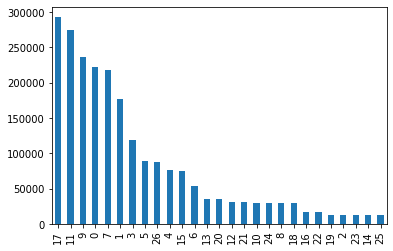

In [5]:
# Example on one team (Club-Season)
subset = dataset.loc[dataset["Team"] == "DCD.C. United2007"].sort_values("Salary", ascending=False)
subset['Salary'].plot(kind="bar")

In [6]:
# Add a column to the dataset "Salary_dist"
df_teams = dataset.groupby("Team").max(["PTS", "Standing"]).sort_index()

for team in df_teams.index:
    subset = dataset.loc[dataset["Team"] == team].sort_values("Salary", ascending=False)
    subset["rank"] = range(len(subset))
    subset["Salary"] = subset["Salary"] / max_salary # subset["Salary"].sum()
    subset = subset.pivot(index="Team", columns="rank", values='Salary')
    df_teams.loc[[team], subset.columns] = subset

df_teams.fillna(0, inplace=True)
df_teams

,PTS,Standing,Season,Salary,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
Team,,,,,,,,,,,,,,,,,,,,,
ATLAtlanta United FC2017,55,4,2017,2297000,0.320474,0.145282,0.107534,0.101151,0.079247,0.057668,...,0.009229,0.009156,0.009069,0.009069,0.009069,0.007395,0.007395,0.007394,0.000000,0.000000
ATLAtlanta United FC2018,69,2,2018,2297000,0.320474,0.198814,0.193557,0.107534,0.097664,0.095571,...,0.009614,0.009592,0.009418,0.009139,0.008162,0.007765,0.007604,0.000000,0.000000,0.000000
CHIChicago Fire FC2007,40,8,2007,2666778,0.372065,0.037321,0.031392,0.026160,0.021137,0.018975,...,0.001800,0.001800,0.001800,0.001800,0.001800,0.000000,0.000000,0.000000,0.000000,0.000000
CHIChicago Fire FC2008,46,3,2008,2666778,0.372065,0.029892,0.027904,0.026415,0.022811,0.018835,...,0.001800,0.001800,0.001800,0.001800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CHIChicago Fire FC2009,45,6,2009,2943702,0.410701,0.053761,0.035577,0.026230,0.022323,0.021364,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VANVancouver Whitecaps FC2014,50,9,2014,1410900,0.196847,0.062783,0.041856,0.039065,0.037134,0.032368,...,0.007464,0.006986,0.006767,0.005093,0.005093,0.000000,0.000000,0.000000,0.000000,0.000000
VANVancouver Whitecaps FC2015,53,3,2015,1410900,0.196847,0.124290,0.045344,0.042214,0.037949,0.036972,...,0.008999,0.008371,0.008371,0.008371,0.008371,0.007653,0.006976,0.000000,0.000000,0.000000
VANVancouver Whitecaps FC2016,39,16,2016,1471400,0.205288,0.105511,0.100523,0.052868,0.051622,0.048134,...,0.008790,0.008720,0.008720,0.008720,0.008179,0.007325,0.007185,0.000000,0.000000,0.000000


In [7]:
df_teams.describe()

,PTS,Standing,Season,Salary,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
count,218.000000,218.000000,218.000000,2.180000e+02,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,...,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000
mean,45.211009,9.825688,2013.050459,1.803554e+06,0.251629,0.139588,0.088792,0.050270,0.041278,0.036077,...,0.006195,0.005638,0.004837,0.004183,0.003276,0.002046,0.000876,0.000317,0.000100,0.000034
std,10.234192,5.639466,3.393165,2.010680e+06,0.280527,0.191941,0.123627,0.034755,0.024370,0.020268,...,0.002714,0.002897,0.003189,0.003252,0.003201,0.002940,0.002156,0.001389,0.000754,0.000501
min,16.000000,1.000000,2007.000000,1.880000e+05,0.026230,0.020091,0.016463,0.015260,0.014370,0.013080,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,38.000000,5.000000,2010.000000,4.527082e+05,0.063161,0.041873,0.031182,0.026762,0.025035,0.022715,...,0.005001,0.004548,0.001800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,46.000000,10.000000,2013.000000,8.904450e+05,0.124234,0.066882,0.045030,0.036449,0.032508,0.028805,...,0.006531,0.006444,0.005581,0.004901,0.003583,0.000000,0.000000,0.000000,0.000000,0.000000
75%,52.000000,14.000000,2016.000000,2.118438e+06,0.295562,0.125248,0.098932,0.065579,0.048832,0.039729,...,0.008371,0.007775,0.007589,0.007185,0.006488,0.004710,0.000000,0.000000,0.000000,0.000000
max,71.000000,23.000000,2018.000000,7.167500e+06,1.000000,0.906871,0.782700,0.209278,0.180677,0.129055,...,0.012028,0.010464,0.009418,0.009418,0.009069,0.009069,0.009069,0.009069,0.007544,0.007394


In [8]:
# Create a target vector to train the model on. Either on Standings or Points (PTS)
y = df_teams['Standing']
y

Team
ATLAtlanta United FC2017          4
ATLAtlanta United FC2018          2
CHIChicago Fire FC2007            8
CHIChicago Fire FC2008            3
CHIChicago Fire FC2009            6
                                 ..
VANVancouver Whitecaps FC2014     9
VANVancouver Whitecaps FC2015     3
VANVancouver Whitecaps FC2016    16
VANVancouver Whitecaps FC2017     8
VANVancouver Whitecaps FC2018    14
Name: Standing, Length: 218, dtype: int64

In [9]:
# Create a sequence of input (training) data
X = df_teams.drop(columns=["PTS", "Standing", "Season", "Salary"])
X

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
Team,,,,,,,,,,,,,,,,,,,,,
ATLAtlanta United FC2017,0.320474,0.145282,0.107534,0.101151,0.079247,0.057668,0.055809,0.045345,0.039764,0.036275,...,0.009229,0.009156,0.009069,0.009069,0.009069,0.007395,0.007395,0.007394,0.000000,0.000000
ATLAtlanta United FC2018,0.320474,0.198814,0.193557,0.107534,0.097664,0.095571,0.086502,0.082037,0.047437,0.034881,...,0.009614,0.009592,0.009418,0.009139,0.008162,0.007765,0.007604,0.000000,0.000000,0.000000
CHIChicago Fire FC2007,0.372065,0.037321,0.031392,0.026160,0.021137,0.018975,0.017649,0.016847,0.014844,0.010882,...,0.001800,0.001800,0.001800,0.001800,0.001800,0.000000,0.000000,0.000000,0.000000,0.000000
CHIChicago Fire FC2008,0.372065,0.029892,0.027904,0.026415,0.022811,0.018835,0.015586,0.015312,0.014998,0.014370,...,0.001800,0.001800,0.001800,0.001800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CHIChicago Fire FC2009,0.410701,0.053761,0.035577,0.026230,0.022323,0.021364,0.019023,0.013987,0.013533,0.013394,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VANVancouver Whitecaps FC2014,0.196847,0.062783,0.041856,0.039065,0.037134,0.032368,0.029438,0.028077,0.024718,0.022463,...,0.007464,0.006986,0.006767,0.005093,0.005093,0.000000,0.000000,0.000000,0.000000,0.000000
VANVancouver Whitecaps FC2015,0.196847,0.124290,0.045344,0.042214,0.037949,0.036972,0.033624,0.031566,0.027508,0.024555,...,0.008999,0.008371,0.008371,0.008371,0.008371,0.007653,0.006976,0.000000,0.000000,0.000000
VANVancouver Whitecaps FC2016,0.205288,0.105511,0.100523,0.052868,0.051622,0.048134,0.044384,0.035368,0.031496,0.026648,...,0.008790,0.008720,0.008720,0.008720,0.008179,0.007325,0.007185,0.000000,0.000000,0.000000


In [10]:
# Use train_test_split to create training and testing data

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(163, 34) (55, 34) (163,) (55,)


In [11]:
# first, create a normal neural network with 2 inputs, 6 hidden nodes, and 2 outputs
tf.keras.backend.clear_session()
model = Sequential()
model.add(Dense(units=40, activation='relu', input_dim=X_train.shape[-1]))
model.add(Dense(units=20, activation='relu'))
model.add(Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40)                1400      
_________________________________________________________________
dense_1 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 2,241
Trainable params: 2,241
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanAbsoluteError(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [13]:
# Fit the model to the training data
history = model.fit(
    X_train,
    y_train,
    epochs=30,
    shuffle=True,
    verbose=1,
    validation_data=(X_test, y_test)
)

Epoch 1/30
6/6 [==============================] - 0s 36ms/step - loss: 9.8194 - mean_absolute_error: 9.8194 - val_loss: 9.8660 - val_mean_absolute_error: 9.8660
Epoch 2/30
6/6 [==============================] - 0s 6ms/step - loss: 9.7583 - mean_absolute_error: 9.7583 - val_loss: 9.8081 - val_mean_absolute_error: 9.8081
Epoch 3/30
6/6 [==============================] - 0s 5ms/step - loss: 9.6996 - mean_absolute_error: 9.6996 - val_loss: 9.7485 - val_mean_absolute_error: 9.7485
Epoch 4/30
6/6 [==============================] - 0s 5ms/step - loss: 9.6366 - mean_absolute_error: 9.6366 - val_loss: 9.6849 - val_mean_absolute_error: 9.6849
Epoch 5/30
6/6 [==============================] - 0s 5ms/step - loss: 9.5679 - mean_absolute_error: 9.5679 - val_loss: 9.6131 - val_mean_absolute_error: 9.6131
Epoch 6/30
6/6 [==============================] - 0s 5ms/step - loss: 9.4905 - mean_absolute_error: 9.4905 - val_loss: 9.5307 - val_mean_absolute_error: 9.5307
Epoch 7/30
6/6 [=======================

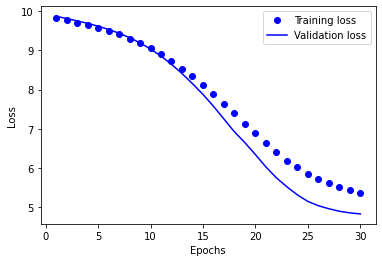

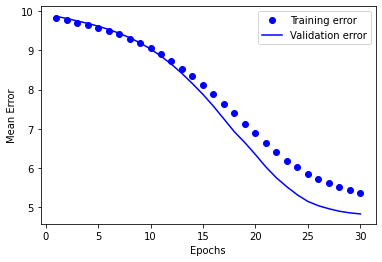

In [14]:
history_dict = history.history
loss_values = history_dict['loss']
test_loss_values = history_dict['val_loss']
acc_values = history_dict['mean_absolute_error']
test_acc_values = history_dict['val_mean_absolute_error']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, test_loss_values, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, 'bo', label='Training error')
plt.plot(epochs, test_acc_values, 'b', label='Validation error')
plt.xlabel('Epochs')
plt.ylabel('Mean Error')
plt.legend()
plt.show()

In [15]:
history_dict.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

In [16]:
model_loss, model_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

2/2 - 0s - loss: 4.8317 - mean_absolute_error: 4.8317
Loss: 4.831689834594727, Accuracy: 4.831689834594727


In [17]:
print("Model predicted:", model.predict(X_test.head(1)))
print("Actual value:", y_test.head(1))

Model predicted: [[8.375637]]
Actual value: Team
DCD.C. United2016    10
Name: Standing, dtype: int64


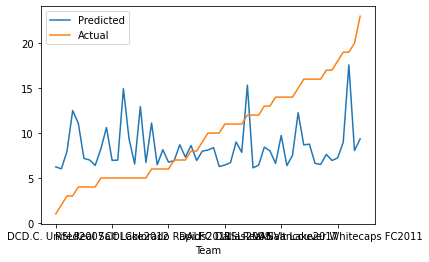

In [18]:
y_predicted = model.predict(X_test)

df_predict = pd.DataFrame(index=X_test.index)
df_predict['Predicted'] = y_predicted
df_predict['Actual'] = y_test
#df_predict['Error'] = np.abs(np.subtract(y_predicted.reshape(y_predicted.shape[0]), y_test.to_numpy()))

df_predict.sort_values("Actual").plot()
plt.show()

In [19]:
a = pd.DataFrame(df_predict[['Actual','Predicted']].sort_values("Actual"))
a['rownum'] = range(len(a))
a.loc[a['rownum'] > 50]

,Actual,Predicted,rownum
Team,,,
TORToronto FC2012,19,8.963270,51
TORToronto FC2018,19,17.585903,52
CHIChicago Fire FC2015,20,8.054658,53
SJSan Jose Earthquakes2018,23,9.345743,54
